<font size="7">Final Project</font>

In [ ]:
!pip install -q torch-lr-finder

In [ ]:
import pandas as pd
import os
import fnmatch
import numpy as np
import shutil
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
import random
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import torch.nn as nn
import torch.nn.functional as F
from torch_lr_finder import LRFinder
import torch.optim as optim
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
seed = 0

<font size="5">**The main purpose of this book is to distinguish between American Sign Language A - E**</font>

# Data preparation

<font size="4">This step is mainly about preparing the data. First I put the same gestures into a folder, so there are five folders in total. Then use '*ImageFolder*' to read the folder for each letter. And then I did transformation, I resized each image to 50 X 50, because if I keep orginal image size, the training process will be very slow and model I created should be more complex(add more layers or reduce each kernel faster).

The second step was to separate the data randomly, I kept 85 percent of the data for my train and the remaining 15 percent for validation.</font>

In [ ]:
parent_dir = '/content'
path = os.path.join(parent_dir, 'img')
os.mkdir(path) 

In [ ]:
parent_dir = '/content/img'
a = ['A', 'B', 'C', 'D', 'E']
for i in a:
  path = os.path.join(parent_dir, i)
  os.mkdir(path) 

In [ ]:
!gdown --id  10ge3QR_9qeKi-9-6TLKpWMWswRrGtGKj  --output "ASL.zip" 

Downloading...
From: https://drive.google.com/uc?id=10ge3QR_9qeKi-9-6TLKpWMWswRrGtGKj
To: /content/ASL.zip
100% 26.3M/26.3M [00:00<00:00, 161MB/s]


In [ ]:
!unzip ASL.zip

In [ ]:
file_name = os.listdir('/content/ASL')


In [ ]:
for f in file_name:

  a = list(f.split('.')[2])[0]
  global_des = '/content/img/' + a
  shutil.move('/content/ASL/' +f, global_des)


In [ ]:
data_dir = '/content'
classes = ('A', 'B', 'C', 'D', 'E')

# Data transformation
train_transforms = transforms.Compose([


    transforms.RandomResizedCrop((50, 50), scale=(0.8, 1.0), 
            ratio=(0.9, 1.1)),
    transforms.ToTensor(),

])
val_transforms = transforms.Compose([

    transforms.ToTensor(),

])


train_ds = datasets.ImageFolder(
    os.path.join(data_dir, 'img'), train_transforms)
val_ds = datasets.ImageFolder(
    os.path.join(data_dir, 'img'), train_transforms)

In [ ]:
torch.manual_seed(seed) 
train_set, _ = torch.utils.data.random_split(train_ds, [357, 63])
torch.manual_seed(seed)
_, val_set = torch.utils.data.random_split(val_ds, [357, 63])

## Train function, Validation function and model class 

<font size="4">I set and class to 5 since I only have 5 stuff(A-E) and modified a little bit about CNN class, I only kept three layers, and three linear. Also, I deleted dropout because this is one of hyper parameter I wanna tune.

For train function and validation function, I didn't do too much stuff, just get the accuracy and loss for either train and validation.
</font>

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes: int = 5, 
                 dropout: float = 0.5) -> None:
        super().__init__()
        
        self.features = nn.Sequential(
            # Conv1
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Conv2
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Conv3
            nn.Conv2d(192, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

        )
        self.avgpool = nn.AdaptiveAvgPool2d((3, 3)) 
        # average pooling, just specify output size
        # https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html


        self.classifier = nn.Sequential(
            # nn.Dropout(p=dropout), # p = dropout probability
            nn.Linear(256 * 3 * 3, 1024),
            nn.ReLU(inplace=True),
            # nn.Dropout(p=dropout),
            nn.Linear(1024, 1024),
            # nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes), 
        )

        # initialize the weights
        self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Based on our previous discussion, we should initialize the convolutions according to the activation function
                # Fan-out focuses on the gradient distribution, 
                # and is commonly used
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)



In [ ]:
def train(device=torch.device("cpu"), scheduler=None):
  net.train()
  running_loss = 0.0
  correct = 0
  total = 0
  for i, data in enumerate(train_loader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs.to(device))
    loss = criterion(outputs, labels.to(device))
    loss.backward()
    optimizer.step()
    if scheduler:
      scheduler.step()

    running_loss += loss.item()

    _, predicted = torch.max(outputs.data.detach().cpu(), 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  # Training loss
  # print(loss)
  # print(loss.item())
  # print(running_loss)
  train_loss.append(running_loss / len(train_loader))


  # Training acc
  train_acc.append(100.*correct/total)



In [ ]:
def validation(testdata_loader, device=torch.device("cpu")):
  correct = 0
  total = 0
  running_loss = 0.0
  net.eval()

  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}


  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
    for data in testdata_loader:
      images, labels = data
      # calculate outputs by running images through the network 
      outputs = net(images.to(device))

      # Calculate loss for validation
      loss = criterion(outputs, labels.to(device))
      running_loss += loss.item()

      # the class with the highest energy is what we choose as prediction
      _, predicted = torch.max(outputs.data.detach().cpu(), 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      
      # collect the correct predictions for each class
      for label, prediction in zip(labels, predicted):
        if label == prediction:
          correct_pred[classes[label]] += 1
        total_pred[classes[label]] += 1

  # Get validation loss and accuracy
  val_loss.append(running_loss/len(val_loader))
  val_acc.append(100.*correct/total)

  # if 100 * correct / total == 100:
  #   return 100

  print("=="*20)
  print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
  print("=="*20)
  # print accuracy for each class
  for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))

  return running_loss/len(val_loader)

# Hyper-parameter tuning

<font size="4">
I tuned three hyper parameters, Batch size, Dropout and Optimal Learning rate.

</font>

## Tuning Batch size: 15, 20, 25

<font size="4">
For the batch size, I picked 15, 20, 25 for tuning purpose, because my data is  small, so batch size can not be too big and not too small, about 15 to 25 will be good. My idea is to test each batch size and train around 10 epoch to see which one has the lowest loss. Lowest one will be better.

</font>

In [ ]:
batch_size_ls = [15, 20, 25]
grid_result = []
for i in batch_size_ls:
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=i, 
        shuffle=True, drop_last=True, pin_memory=True, num_workers=2)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size=i, 
          shuffle=False, drop_last=False, num_workers=2)
  
  net = CNN(num_classes= 5, dropout=0.5)
  net.to(device)
  data_loader = val_loader
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
  train_loss = []
  train_acc = []
  val_loss = []
  val_acc = []
  a = 5
  loss_cv = []
  for i in range(10):
    print(i)
    train(device=device, scheduler=None)
    val_checker = validation(val_loader, device=device)
    if a > val_checker:
      PATH = './cnn2.pth'
      torch.save(net.state_dict(), PATH)
      print('Saved!')
      print(val_checker)
      loss_cv.append(val_checker)
      a = val_checker
  grid_result.append(a)
print('Done all')

0
Accuracy of the network on the test images: 17 %
Accuracy for class A     is: 100.0 %
Accuracy for class B     is: 0.0 %
Accuracy for class C     is: 0.0 %
Accuracy for class D     is: 0.0 %
Accuracy for class E     is: 0.0 %
Saved!
1.6092792987823485
1
Accuracy of the network on the test images: 17 %
Accuracy for class A     is: 100.0 %
Accuracy for class B     is: 0.0 %
Accuracy for class C     is: 0.0 %
Accuracy for class D     is: 0.0 %
Accuracy for class E     is: 0.0 %
Saved!
1.605168390274048
2
Accuracy of the network on the test images: 17 %
Accuracy for class A     is: 100.0 %
Accuracy for class B     is: 0.0 %
Accuracy for class C     is: 0.0 %
Accuracy for class D     is: 0.0 %
Accuracy for class E     is: 0.0 %
Saved!
1.5959771156311036
3
Accuracy of the network on the test images: 36 %
Accuracy for class A     is: 81.8 %
Accuracy for class B     is: 38.5 %
Accuracy for class C     is: 0.0 %
Accuracy for class D     is: 81.8 %
Accuracy for class E     is: 0.0 %
Saved!
1.5

In [ ]:
grid_result

[1.3815616846084595, 1.5300492644309998, 1.5698815981547039]

<font size="4">The result I can see that 15 batch size is better than another two, so I will use for rest of work!</font>

## Tuning Dropout:0.5 0.6 0.7 and No Dropout

<font size="4">Now, I'll tuning dropout between 0.5, 0.6 and 0.7, and see how it goes. Dropout is to prevent overfitting, the reason I picked these three number because I did some of the research about dropout, it shows is better to set around 0.5 til 0.8. I ran a few model before this notebook, and I haven't met overfitting yet, so I just test see if it will perform a better result or not. The idea of this tuning is same as batch size. However, I will compare the result for 0.5 0.6 0.7 and not use it at all(Last tuning I have not use any dropout, the loss about 1.38). </font>

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes: int = 5, 
                 dropout: float = 0.5) -> None:
        super().__init__()
        
        self.features = nn.Sequential(
            # Conv1
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Conv2
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Conv3
            nn.Conv2d(192, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

        )
        self.avgpool = nn.AdaptiveAvgPool2d((3, 3)) 
        # average pooling, just specify output size
        # https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html


        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout), # p = dropout probability
            nn.Linear(256 * 3 * 3, 520),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(520, 520),
            nn.ReLU(inplace=True),
            nn.Linear(520, num_classes), 
        )

        # initialize the weights
        self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Based on our previous discussion, we should initialize the convolutions according to the activation function
                # Fan-out focuses on the gradient distribution, 
                # and is commonly used
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)



In [ ]:
dropout_ls = [0.5, 0.6, 0.7]
grid2_result = []
batch_size = 15
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
      shuffle=True, drop_last=True, pin_memory=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, 
        shuffle=False, drop_last=False, num_workers=2)

for i in dropout_ls:
  
  net = CNN(num_classes= 5, dropout=i)
  net.to(device)
  data_loader = val_loader
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
  train_loss = []
  train_acc = []
  val_loss = []
  val_acc = []
  a = 5
  loss_cv = []
  for i in range(10):
    print(i)
    train(device=device, scheduler=None)
    val_checker = validation(val_loader, device=device)
    if a > val_checker:
      PATH = './cnn2.pth'
      torch.save(net.state_dict(), PATH)
      print('Saved!')
      print(val_checker)
      loss_cv.append(val_checker)
      a = val_checker
  grid2_result.append(a)
print('Done all')


0
Accuracy of the network on the test images: 28 %
Accuracy for class A     is: 36.4 %
Accuracy for class B     is: 0.0 %
Accuracy for class C     is: 100.0 %
Accuracy for class D     is: 0.0 %
Accuracy for class E     is: 0.0 %
Saved!
1.6092472553253174
1
Accuracy of the network on the test images: 28 %
Accuracy for class A     is: 90.9 %
Accuracy for class B     is: 0.0 %
Accuracy for class C     is: 57.1 %
Accuracy for class D     is: 0.0 %
Accuracy for class E     is: 0.0 %
Saved!
1.6082975149154664
2
Accuracy of the network on the test images: 38 %
Accuracy for class A     is: 63.6 %
Accuracy for class B     is: 0.0 %
Accuracy for class C     is: 92.9 %
Accuracy for class D     is: 36.4 %
Accuracy for class E     is: 0.0 %
Saved!
1.6059561967849731
3
Accuracy of the network on the test images: 53 %
Accuracy for class A     is: 63.6 %
Accuracy for class B     is: 23.1 %
Accuracy for class C     is: 92.9 %
Accuracy for class D     is: 100.0 %
Accuracy for class E     is: 0.0 %
Saved

In [ ]:
grid2_result

[1.588193917274475, 1.5883011102676392, 1.593526339530945]

<font size="4">All three results were very close, but it was obvious that the loss would be lower if without the dropout, so I decided not to use the dropout.</font>

## Tuning Optimal learning rate

<font size="4">
The third hyper parameter tuning is optimal learning rate, which I can use in training process.
</font>

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes: int = 5, 
                 dropout: float = 0.5) -> None:
        super().__init__()
        
        self.features = nn.Sequential(
            # Conv1
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Conv2
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Conv3
            nn.Conv2d(192, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

        )
        self.avgpool = nn.AdaptiveAvgPool2d((3, 3)) 
        # average pooling, just specify output size
        # https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html


        self.classifier = nn.Sequential(
            # nn.Dropout(p=dropout), # p = dropout probability
            nn.Linear(256 * 3 * 3, 1024),
            nn.ReLU(inplace=True),
            # nn.Dropout(p=dropout),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes), 
        )

        # initialize the weights
        self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Based on our previous discussion, we should initialize the convolutions according to the activation function
                # Fan-out focuses on the gradient distribution, 
                # and is commonly used
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)



In [ ]:
net = CNN(num_classes= 5, dropout=0.5)
net.to(device)
data_loader = val_loader # <----

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.SGD(net.parameters(), lr=1E-5, momentum=0.9)
lr_finder = LRFinder(net, optimizer, criterion, device=device)
lr_finder.range_test(data_loader, end_lr=1, num_iter=100, step_mode="exp")

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 3.05E-02


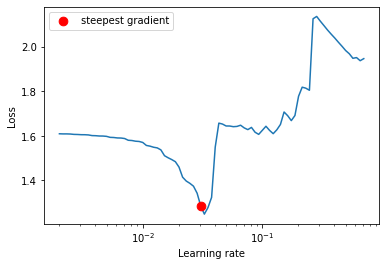

(<matplotlib.axes._subplots.AxesSubplot at 0x7f55ffd77f50>,
 0.03053855508833416)

In [ ]:
lr_finder.plot()

<font size="4">The plot above pointed out the steepest grandient, but just for reference. I should take the value a little before the steepest point.</font>

In [ ]:
!curl -o onecyclelr.py  https://raw.githubusercontent.com/dkumazaw/onecyclelr/master/onecyclelr.py
from onecyclelr import OneCycleLR

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5243  100  5243    0     0  32565      0 --:--:-- --:--:-- --:--:-- 32565


<font size="4">After I viewed the plot, the range should between 10-2 and 10-1, for optimizer, I just used upper bond. Then I will put my scheduler into my training process.
</font>

In [ ]:
lr_finder.reset() #<--- !! important
net = CNN(num_classes=5, dropout=0.5)

net.to(device) # to GPU
optimizer = torch.optim.SGD(net.parameters(), lr=1.E-2, momentum=0.9)
scheduler = OneCycleLR(optimizer, num_steps=len(train_loader), lr_range=(1.E-2, 1.E-1))

# Modeling

<font size="4">**Another exciting time has arrived！！** By the time I get here I have processed the data preparation and found the best hyper parameters.

I redo most of things here just make sure the previous stuff won't mass my model.

For the hyper parameter I used 15 as my batch size, no dropout, call scheduler I just defined. Rest the stuff would be same as previous. Ran 150 epochs, because I wanna see where to start overfit, because I don't want my model overfit.
</font>

In [ ]:
data_dir = '/content'
classes = ('A', 'B', 'C', 'D', 'E')

# Data transformation
train_transforms = transforms.Compose([

    transforms.RandomResizedCrop((40, 40), scale=(0.8, 1.0), 
            ratio=(0.9, 1.1)),
    transforms.ToTensor(),

])
val_transforms = transforms.Compose([

    transforms.ToTensor(),

])

# Read the train set from folder
train_ds = datasets.ImageFolder(
    os.path.join(data_dir, 'img'), train_transforms)
val_ds = datasets.ImageFolder(
    os.path.join(data_dir, 'img'), train_transforms)

In [ ]:
# Set batch size
batch_size = 15


torch.manual_seed(seed) 
train_set, _ = torch.utils.data.random_split(train_ds, [357, 63])
torch.manual_seed(seed)
_, val_set = torch.utils.data.random_split(val_ds, [357, 63])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
        shuffle=True, drop_last=True, pin_memory=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, 
        shuffle=False, drop_last=False, num_workers=2)

In [ ]:
for images, labels in train_loader:
    pass

# Get one batch
images, labels = next(iter(train_loader))
images.shape  # Output: torch.Size([30, 3, 500, 500])    [how many images, kernel(rgb), wide, length]

torch.Size([15, 3, 40, 40])

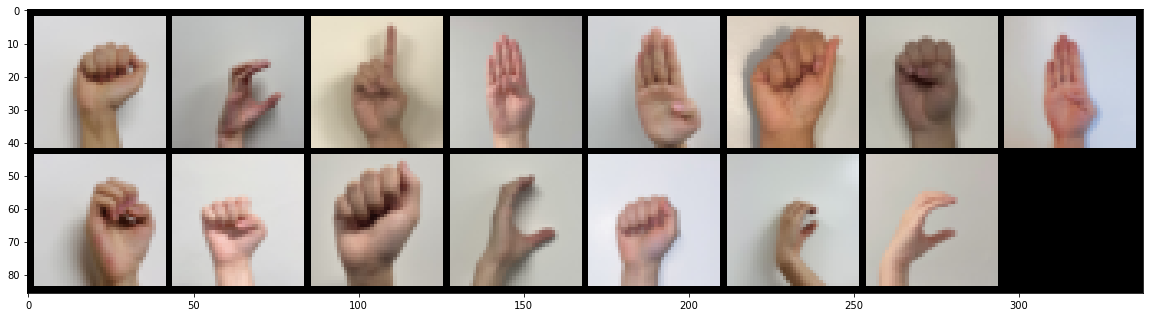

In [ ]:
def imshow(img):

  # img = img / 2 + 0.5
  npimg = img.numpy()
  plt.figure(figsize=(20,20))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()
imshow(torchvision.utils.make_grid(images))


In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes: int = 5, 
                 dropout: float = 0.5) -> None:
        super().__init__()
        
        self.features = nn.Sequential(
            # Conv1
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Conv2
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Conv3
            nn.Conv2d(192, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

        )
        self.avgpool = nn.AdaptiveAvgPool2d((3, 3)) 
        # average pooling, just specify output size
        # https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html


        self.classifier = nn.Sequential(
            # nn.Dropout(p=dropout), # p = dropout probability
            nn.Linear(256 * 3 * 3, 1024),
            nn.ReLU(inplace=True),
            # nn.Dropout(p=dropout),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes), 
        )

        # initialize the weights
        self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Based on our previous discussion, we should initialize the convolutions according to the activation function
                # Fan-out focuses on the gradient distribution, 
                # and is commonly used
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)



In [ ]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []
a = 0.5

In [ ]:
for i in range(150):
  print(i)
  train(device=device, scheduler=scheduler)
  val_checker = validation(val_loader, device=device)
  if a > val_checker:
    PATH = './cnn2.pth'
    torch.save(net.state_dict(), PATH)
    print('Saved!')
    print(val_checker)
    a = val_checker

print('Done all')

0
Accuracy of the network on the test images: 96 %
Accuracy for class A     is: 100.0 %
Accuracy for class B     is: 100.0 %
Accuracy for class C     is: 100.0 %
Accuracy for class D     is: 90.9 %
Accuracy for class E     is: 92.9 %
1
Accuracy of the network on the test images: 90 %
Accuracy for class A     is: 100.0 %
Accuracy for class B     is: 84.6 %
Accuracy for class C     is: 100.0 %
Accuracy for class D     is: 100.0 %
Accuracy for class E     is: 71.4 %
2
Accuracy of the network on the test images: 96 %
Accuracy for class A     is: 100.0 %
Accuracy for class B     is: 100.0 %
Accuracy for class C     is: 100.0 %
Accuracy for class D     is: 90.9 %
Accuracy for class E     is: 92.9 %
3
Accuracy of the network on the test images: 88 %
Accuracy for class A     is: 90.9 %
Accuracy for class B     is: 92.3 %
Accuracy for class C     is: 100.0 %
Accuracy for class D     is: 100.0 %
Accuracy for class E     is: 64.3 %
4
Accuracy of the network on the test images: 96 %
Accuracy for c

# Results

<font size="4">I re-defind validation function because I want to show confusion matrix and also modified a little bit about result to show.

I also show the loss curve and accuracy curve. Unfortunately, I didn't get to meet overfit, which is a good thing, eventhough I set epoch very high.
</font>

In [ ]:
def validation(testdata_loader, device=torch.device("cpu")):
  correct = 0
  total = 0
  running_loss = 0.0
  a =[]
  b = []
  net.eval()

  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}


  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
    for data in testdata_loader:
      images, labels = data
      # calculate outputs by running images through the network 
      outputs = net(images.to(device))

      # Calculate loss for validation
      loss = criterion(outputs, labels.to(device))
      running_loss += loss.item()

      # the class with the highest energy is what we choose as prediction
      _, predicted = torch.max(outputs.data.detach().cpu(), 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      
      # collect the correct predictions for each class
      for label, prediction in zip(labels, predicted):
        a.append(label.item())
        b.append(prediction.item())
        if label == prediction:
          correct_pred[classes[label]] += 1
        total_pred[classes[label]] += 1

  # Get validation loss and accuracy
  val_loss.append(running_loss/len(val_loader))
  val_acc.append(100.*correct/total)

  # if 100 * correct / total == 100:
  #   return 100

  print("=="*25)
  print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
  print("=="*25)
  # print accuracy for each class
  for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))
  print("=="*25)
  print('confusion Matrix:')
  print(confusion_matrix(a, b))
  print("=="*25)
  print('Loss:')
  return running_loss/len(val_loader)

<font size="4">
As I mentioned, I tested result mutiple times before, one of accuracy curve, the train curve increased when epoch increase, but validation curve was lousy. One of the reason might be I mess up the during training process, and the validation set is not balance. So I look back, and make some changes.

But the plot below still not stable, the fluctuation is still a bit large, but compared to the previous but much better.  :)
</font>

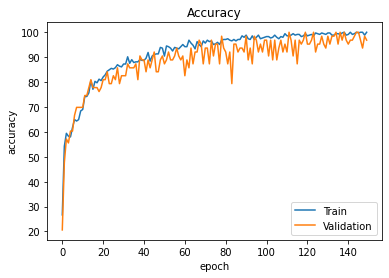

In [ ]:
# acc plot  
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Validation'])
plt.title('Accuracy')
plt.show()


<font size="4">
Loss cuve will be similar for accuracy, and I found something very interesting, low loss not means high accuracy, for example, one of loss is like somthing around 0.07, but accuracy is 98%. But sometimes, when accuracy goes 100%, loss maybe like 0.1. However, in most of situation, when validation 100% correct, loss will be lower.
</font>

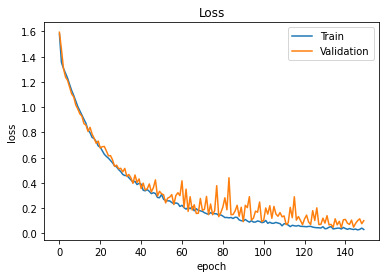

In [ ]:
# loss plot  
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Validation'])
plt.title('Loss')
plt.show()

I predicted all the validation image correctly. <font color='red'>The number only appear on diagnose if 100% accuracy in confusion matrix</font>

In [ ]:
net = CNN(num_classes=5, dropout=0.5) 
PATH = './cnn2.pth'
net.load_state_dict(torch.load(PATH))
_ = net.to(device)
validation(val_loader, device=device)

Accuracy of the network on the test images: 100 %
Accuracy for class A     is: 100.0 %
Accuracy for class B     is: 100.0 %
Accuracy for class C     is: 100.0 %
Accuracy for class D     is: 100.0 %
Accuracy for class E     is: 100.0 %
confusion Matrix:
[[11  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 0  0  0 11  0]
 [ 0  0  0  0 14]]
Loss:


0.04510008841753006

<font size="5">In conclusion, The model performed just ok, it takes too many step and very long time to get the higher accuracy. However, it is a good pratice and learning how to write our own CNN model.</font>